# Manifold Learning

- Clustering:  Two “close” points should be in the same cluster.
- Dimensionality Reduction:  “Closeness” should be preserved.
- Semi-Supervised, Supervised: Two “close” points should have the same label

## “closeness” is further refined using the distribution of the data

- Probabilistic viewpoint: density shortens the distances
- Cluster viewpoint: points in connected regions share the same properties
- Manifold viewpoint: distance should be measured “along” the data manifold
- Mixed version: two “close” points are those connected by a short path going through high density regions

## Manifold learning methods

- MDS:
- ISOMAP: Infer a distance matrix using distances along the manifold.
- LLE(Locally Linear Embedding): Find a mapping to preserve local linear relationships between neighbors.
- Laplacian Eigenmaps
    * spectral method similar to LLE
    * better preserves clusters in data
- Kernel PCA
- Self-Organizing Map 

## MDS

距离矩阵$A$的每一个元素为$a_{ij}$  
降维后的数据表示为$z_i$  
$a_{ij}^2 = \left | \mathbf{z_i-z_j} \right |^2 = \left | \mathbf{z_i} \right |^2 + \left | \mathbf{z_j} \right |^2 - 2\mathbf{z_i}\mathbf{z_j}^T$  
令内积矩阵 $e_{ij}=\mathbf{z_i}\mathbf{z_j}^T$  
$e_{ij} = -\frac{1}{2}(a_{ij}^2-a_{i\cdot} - a_{\cdot j}-a_{\cdot\cdot}^2)$  
$E=e_{ij}=V\Lambda V^T$  
$Z=\Lambda^{\frac{1}{2}}V^T$  
取d个最大特征值构成$\widetilde{V}$，对应的特征向量按序排列构成$\widetilde{\Lambda}$

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
def make_hello(N=1000, rseed=42, word="HELLO"):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, word, va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

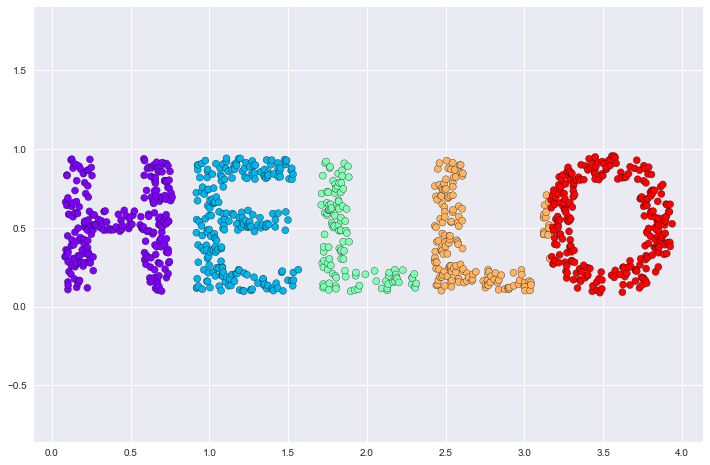

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5),edgecolors='black')
fig = plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

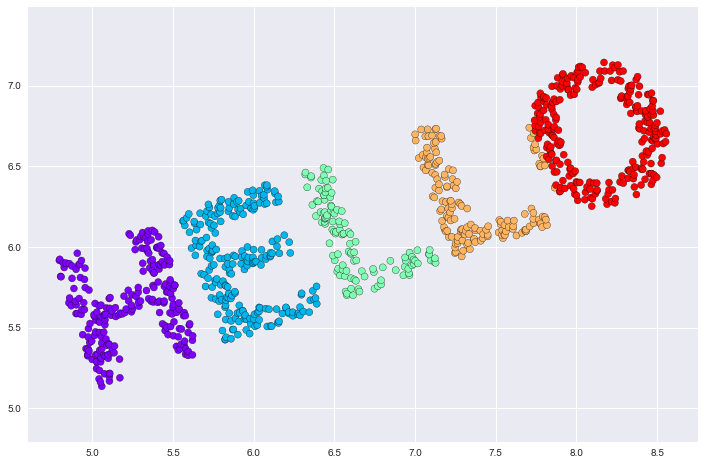

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
fig = plt.figure(figsize=(12,8))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

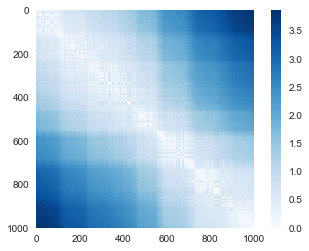

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

(-1.0348994812626031,
 1.033606469486162,
 -2.0583424219338387,
 2.1291346609676207)

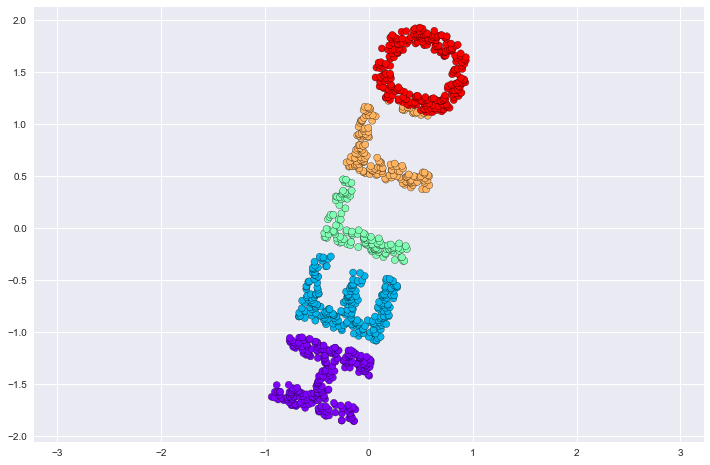

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
fig=plt.figure(figsize=(12,8))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

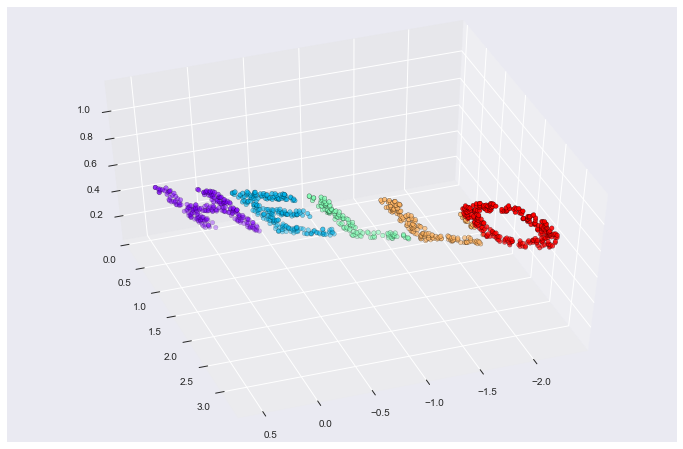

In [10]:
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

(-1.0348994812626058,
 1.0336064694861646,
 -2.0583424219338378,
 2.1291346609676194)

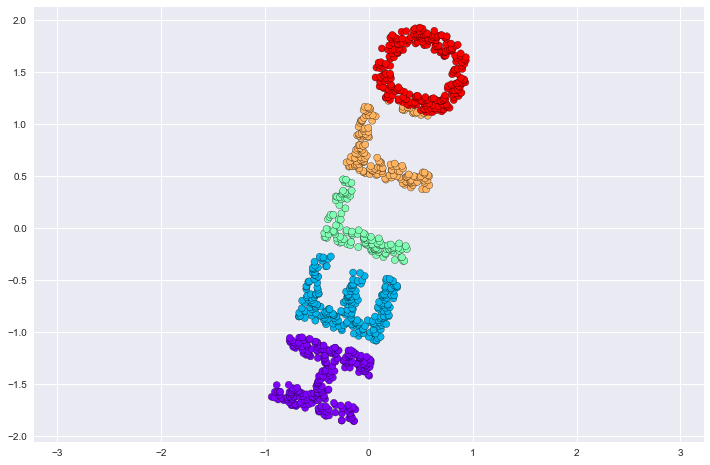

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
fig = plt.figure(figsize=(12,8))
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

### When MDS Failed
嵌入表示是非线性关系

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

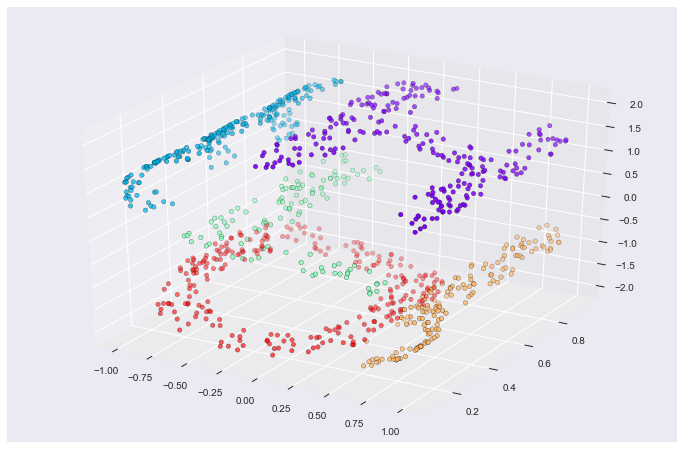

In [13]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

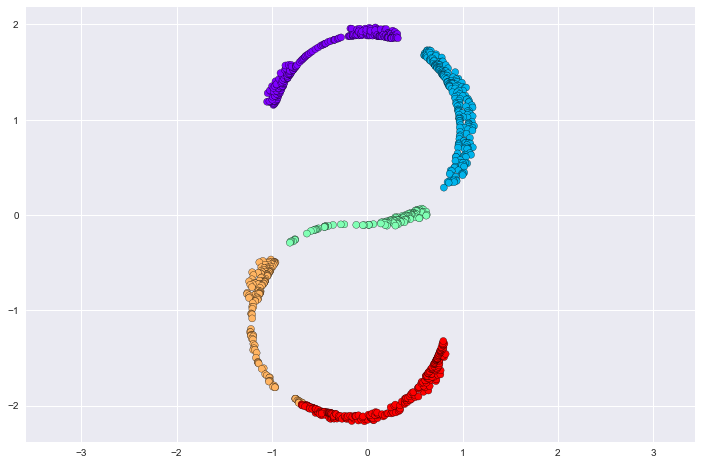

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
fig = plt.figure(figsize=(12,8))
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

## LLE

流形学习的局部区域具有欧式空间的性质，那么在LLE中就假设某个点$x_i$坐标可以由它周围的一些点的坐标线性组合求出   
即$\mathbf{x_i} = \sum_{j\in X_i}f_{ij} \mathbf{x_j}$，其中$X_i$表示$x_i$的邻域上点的集合  
由于这种关系在低维空间中也被保留，因此  
$\mathbf{z_i} = \sum_{j\in Z_i}f_{ij} \mathbf{z_j}$   
以如下目标函数求解权重$F$  
$\underset{f_1,…,f_K}{min} \; \sum_{k=1}^K\left | \mathbf{x_i}- \sum_{j\in X_i}f_{ij}\mathbf{x_j} \right |   \;\;\;\;\;\;\;\; s.t.\sum_{j\in X_i}f_{ij}=1 \ $  
求出权重之后，代入低维空间的优化目标  
$\underset{z_1,…,z_K}{min}  \sum_{k=1}^K\left | \mathbf{z_i}- \sum_{j\in Z_i}f_{ij}\mathbf{z_j} \right |$  

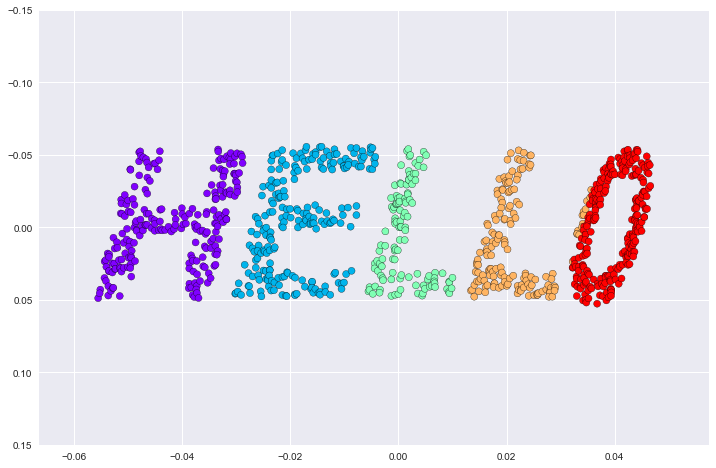

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

In [16]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

#X = make_hello(1000)
XS = make_hello_s_curve(X)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

d:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
d:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


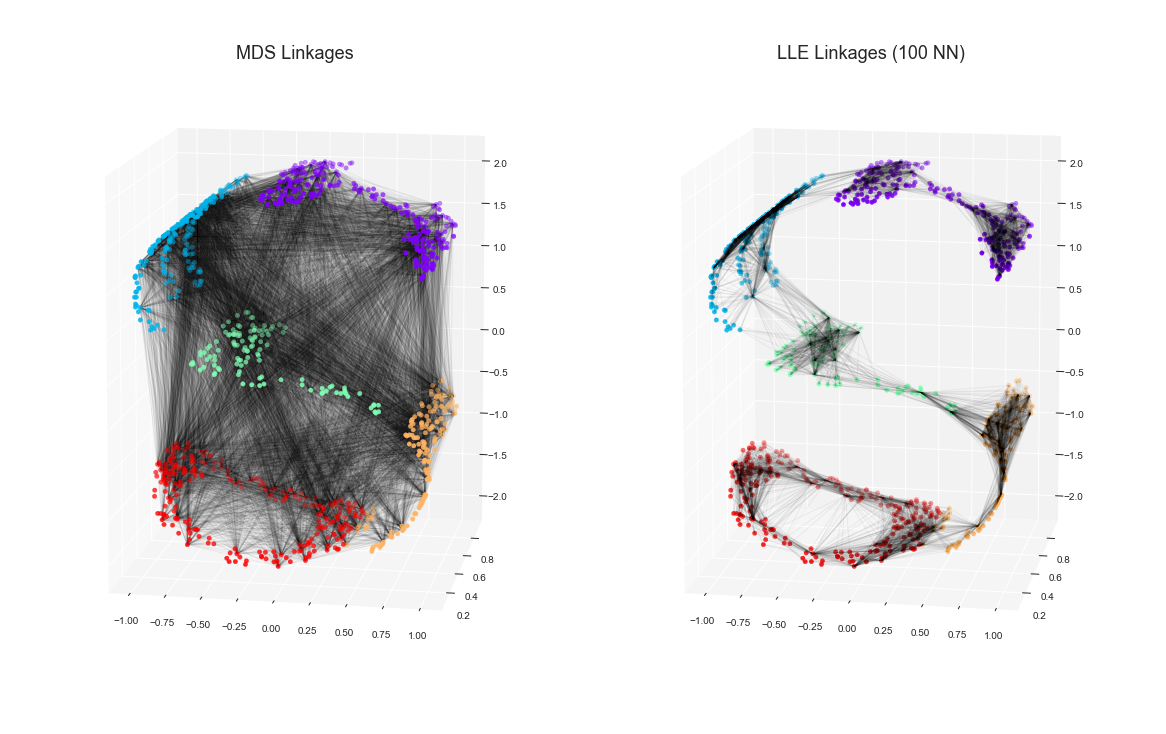

In [17]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 10),
                       subplot_kw=dict(projection='3d', axisbg='none'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

#fig.savefig('figures/05.10-LLE-vs-MDS.png')

## Isomap on Faces

Isomap(等度量映射)  
结合流形学习的基本思想和MDS来进行降维  
距离矩阵$A_{ij}$中的元素按照如下方式填充：  
- 由KNN先构造A的一部分，即求出相邻的点并取它们的欧式距离填入$A_{ij}$，其他的位置全部初始化为无穷大  
- 根据最短路径算法(Dijkstra算法)找到距离比较近的点之间的路径并填入距离  
- 将距离矩阵A作为MDS的输入，得到输出

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
d:\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
d:\Anaconda3\lib\site-packages\sklea

(2370, 2914)

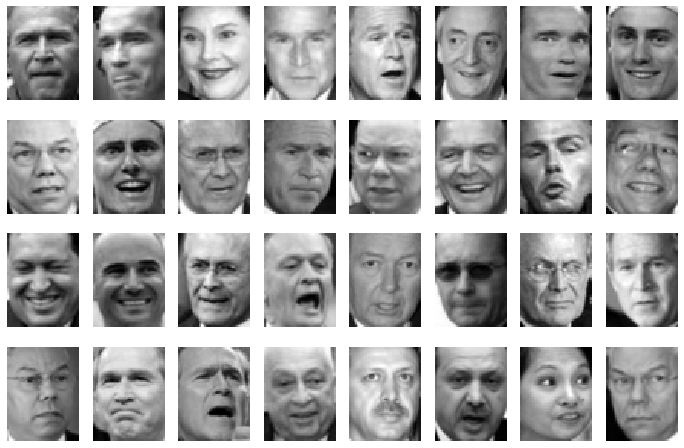

In [20]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]),figsize=(12,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

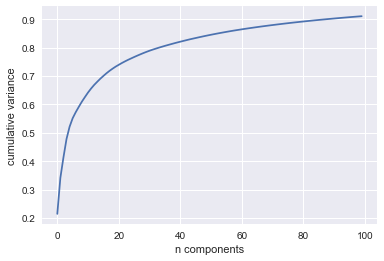

In [22]:
from sklearn.decomposition import PCA
model = PCA(100,svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [23]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [24]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

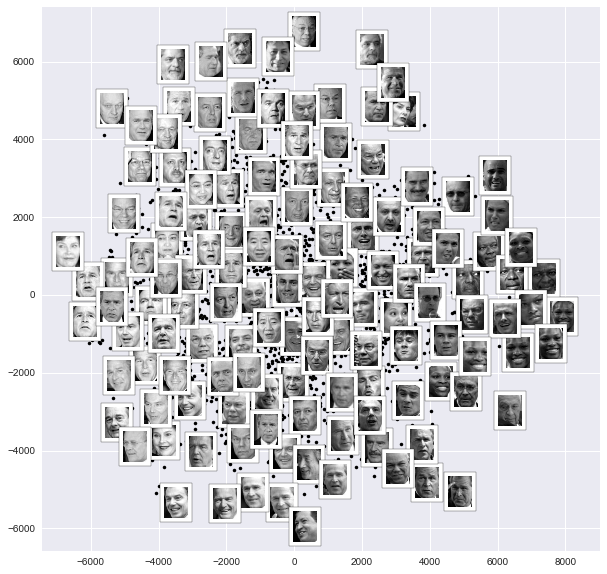

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

## Visualizing Structure in Digits

In [29]:
#from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')
#mnist.data.shape

In [30]:
from scipy.io import loadmat
mnist_path = "mnist-original.mat" #type the directory where you want to the file is located
mnist_raw = loadmat(mnist_path)
mnist = {
"data": mnist_raw["data"].T,
"target": mnist_raw["label"][0],
"COL_NAMES": ["label", "data"],
"DESCR": "mldata.org dataset: mnist-original",
}

In [33]:
mnist["data"].shape

(70000, 784)

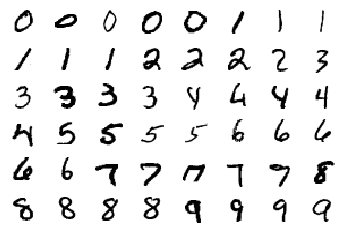

In [34]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist["data"][1250 * i].reshape(28, 28), cmap='gray_r')

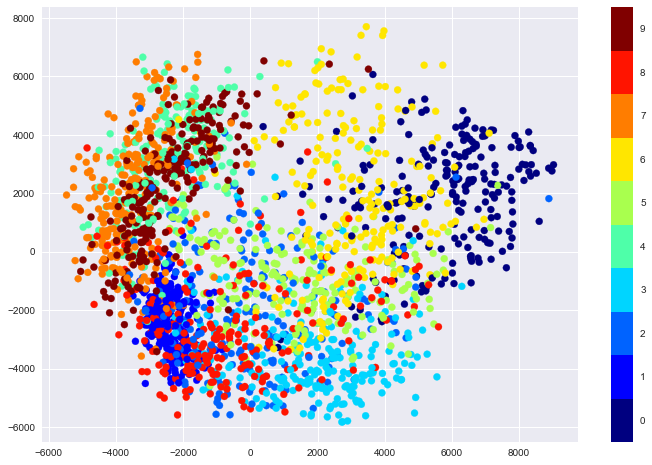

In [35]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist["data"][::30]
target = mnist["target"][::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.figure(figsize=(12,8))
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

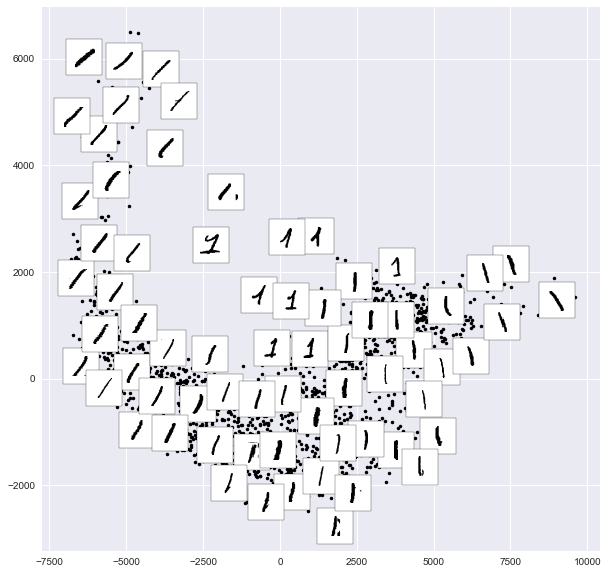

In [36]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist["data"][mnist["target"] == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

- For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well.  
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings.   
- For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods.

## 拉普拉斯特征映射（Laplacian Eigenmaps）

拉普拉斯矩阵定义：  
给定一个有$n$个顶点的图$G=（V，E）$, Laplacian矩阵定义为：$L=D-W$  
其中$D$为图的度矩阵，$W$为图的邻接矩阵

Laplacian矩阵性质：
1. 拉普拉斯矩阵是半正定矩阵；
2. 特征值中0出现的次数就是图连通区域的个数；
3. 最小特征值是0，因为拉普拉斯矩阵每一行的和均为0；
4. 最小非零特征值是图的代数连通度

设数据实例的数目为$n$，目标子空间即最终的降维目标的维度为$m$。定义$n×m$大小的矩阵$Y$，其中每一个行向量$y_i^T$是数据实例$i$在目标$m$维子空间中的向量表示（即降维后的数据实例$i$）
拉普拉斯特征影视优化目标：  
$$min\sum\limits_{i,j}||y_i-y_j||^2W_{ij}$$

推导：
$$
\sum_{i=1}^{n}\sum_{j=1}^{n}||y_i-y_j||^2W_{ij}
\\=\sum_{i=1}^{n}\sum_{j=1}^{n}(y_i^Ty_i-2y_i^Ty_j+y_j^Ty_j)W_{ij}
\\= \sum_{i=1}^{n}(\sum_{j=1}^nW_{ij})y_i^Ty_i+\sum_{j=1}^{n}(\sum_{i=1}^nW_{ij})y_j^Ty_j-2\sum_{i=1}^{n}\sum_{j=1}^{n}y_i^Ty_jW_{ij}
\\=2\sum_{i=1}^{n}D_{ii}y_i^Ty_i-2\sum_{i=1}^{n}\sum_{j=1}^{n}y_i^Ty_jW_{ij}
\\=2\sum_{i=1}^{n}(\sqrt{D_{ii}}y_i)^T(\sqrt{D_{ii}}y_i)-2\sum_{i=1}^ny_i^T(\sum_{j=1}^ny_jW{ij})
\\=2trace(Y^TDY) - 2\sum_{i=1}^ny_i^T(YW)_i
\\=2trace(Y^TDY)-2trace(Y^TWY)
\\=2trace[Y^T(D-W)Y]
\\=2trace(Y^TLY)
$$

得到：
$$min\quad trace(Y^TLY),\quad s.t. Y^TDY=I$$

求解得：$LY=-DY\Lambda$

步骤1：构建图  
使用某一种方法来将所有的点构建成一个图，例如使用KNN算法，将每个点最近的K个点连上边。K是一个预先设定的值.  
  
步骤2：确定权重  
确定点与点之间的权重大小，例如选用热核函数来确定，如果点i和点j相连，那么它们关系的权重设定为：  
$W_{ij}=e^{-\frac{||x_i-x_j||^2}{t}}$  
另外一种可选的简化设定是$W_{ij}=1$如果点$i，j$相连，否则$W_{ij}=0$。  
  
步骤3：特征映射  
计算拉普拉斯矩阵L的特征向量与特征值：$Ly=λDy$  
使用最小的m个非零特征值对应的特征向量作为降维后的结果输出。

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

- Uses the local relationships to capture non-linear structure  
- Using the Gaussian distribution that defines the relationships between the points in high-dimensional space  
- Uses the Student t-distribution to recreate the probability distribution in low-dimensional space (curse of dimensionality)
- Optimizes using gradient descent

### Step 1:  
In the high-dimensional space, create a probability distribution that dictates the relationships between various neighboring points

pick a point $x_i$, the probability of picking another point $ x_j $ in the dataset as the neighbor as

$p_{ij}= \frac{\exp(-\left\|x_i-x_j\right\|^2/2\sigma_i^2)}{\sum_{k \neq I}\exp(-\left \|x_k-x_I\right \|^2/2\sigma_i^2)}$

$\sigma_i$ is controled by a hyperparamer called perplexity, basically between (5,50)

### Step 2:  
It then tries to recreate a low dimensional space that follows that probability distribution as best as possible.

express the low-dimensional mapping of $x_i$ as $y_i$ 

Student t-distribution with a single degree of freedom (which is also known as the Cauchy distribution):  
$q_{ij}=\frac{(1+\left \|y_i-y_j\right \|)^{-1}}{\sum_{k \neq I}(1+\left \|y_k-y_I\right \|)^{-1})}$

### Step 3:  


Optimizing this distribution is done by conducting gradient descent on the KL-divergence between the distributions $p$ and $q$,  
The gradient can be expressed as:  
$\frac{\delta_J}{\delta_y}=4\sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+\left \|y_i-y_j\right \|^2)^{-1}$

### Tricks:
1. Early compression
2. Early exaggeration

In [40]:
X = mnist["data"] / 255.0
y = mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


In [43]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None


print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


In [44]:
rndperm = np.random.permutation(df.shape[0])

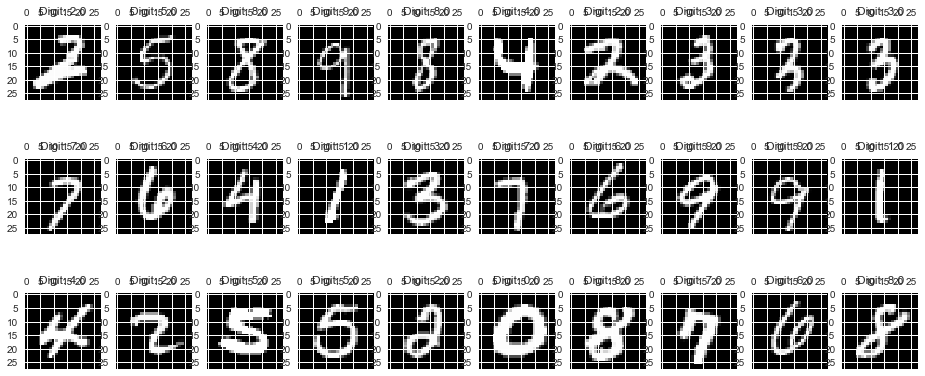

In [46]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1, title='Digit: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))

plt.show()

In [47]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.562s...
[t-SNE] Computed neighbors for 7000 samples in 68.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 2.220620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.457848
[t-SNE] Error after 300 iterations: 2.426031
t-SNE done! Time elapsed: 147.15397357940674 seconds


In [48]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [49]:
df_tsne.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
16158     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
65545     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
68037     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
54942     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
53363     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel9    ...     pixel777  pixel778  pixel779  pixel780  pixel781  \
16158     0.0    ...          0.0       0.0       0.0       0.0       0.0   
65545     0.0    ...          0.0       0.0       0.0       0.0       0.0   
68037     0.0    ...          0.0       0.0       0.0       0.0       0.0   
54942     0.0    ...          0.0       0.0       0.0       0.0       0.0   
53363     0.0    ...          0.0       0.0       0.0       0.0       0.0   

       pixel782  pixel783  label    x-tsne    y-tsne  
16158       0.0       0.0    2.0  9.748317  1.124637  
65545       0.0       0.0    5.0 -0.748136 -5.077913  
68037       0.0       0.0    8.0  2.296673 -0.648254  
54942       0.0       0.0    9.0 -7.615716 -1.374935  
53363       0.0       0.0    8.0  1.944520  0.221256  

[5 rows x 787 columns]

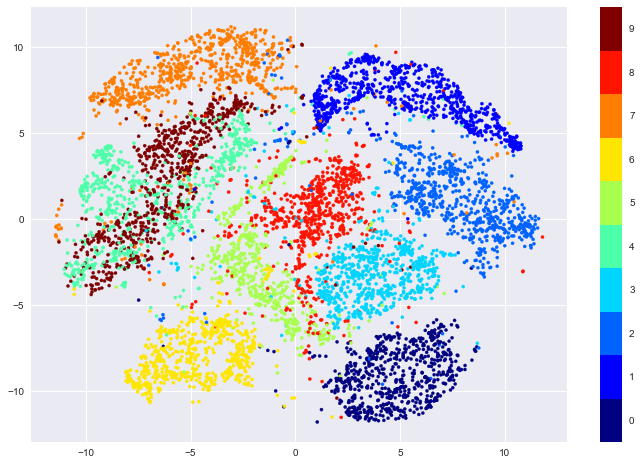

In [54]:
plt.figure(figsize=(12,8))
plt.scatter(df_tsne["x-tsne"], df_tsne["y-tsne"], c=df_tsne.label, s=10,cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

## 关于流形学习的总结

目前而言，流形学习的最多的应用是对高维数据进行定性的可视化分析而并无其他显著作用，主要是因为：

- 流形学习中，并没有很好的框架来处理确实数据。
- 数据中的噪声会对流形产生“短路”作用致使效果大受影响。
- 大多数流形学习算法都高度依赖于选择近邻的数量，目前并没有一个稳定的量化方法来确定其最优值。
- 很难确定输出维度数量的最优值。
- 嵌入维度的可解释性比较差。
- 流形学习算法的时间复杂度大多是$O(n^2)$或者$O(n^3)$